In [180]:
from pathlib import Path
import os
import glob

current_dir = Path.cwd()
data_dir = current_dir.parent/'raw_data'
viz_dir = current_dir.parent/'visualizations'

snow_or_ice_311complaint_file = glob.glob(f'{data_dir}/*311*.parquet')
print(snow_or_ice_311complaint_file)

['/Users/keenansmacbookairm3/Documents/GitHub/SnowDay_NYC/raw_data/snow_or_ice_311Complaints.parquet']


In [181]:
import pandas as pd
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_column', None)
pd.set_option('display.max_row', 30)

import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns

In [182]:
df = pd.read_parquet(snow_or_ice_311complaint_file)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26630 entries, 0 to 26629
Data columns (total 39 columns):
 #   Column                          Non-Null Count  Dtype 
---  ------                          --------------  ----- 
 0   unique_key                      26630 non-null  object
 1   created_date                    26630 non-null  object
 2   closed_date                     24436 non-null  object
 3   agency                          26630 non-null  object
 4   agency_name                     26630 non-null  object
 5   complaint_type                  26630 non-null  object
 6   descriptor                      26630 non-null  object
 7   descriptor_2                    26630 non-null  object
 8   location_type                   26630 non-null  object
 9   status                          26630 non-null  object
 10  resolution_description          24497 non-null  object
 11  resolution_action_updated_date  24542 non-null  object
 12  community_board                 26630 non-null

In [280]:
df.resolution_description.unique()

array(['Your report was submitted and will be used to monitor snow conditions around the City. The Department of Sanitation has a winter storm operation currently underway and cannot respond to individual requests at this time. No further status will be available about your report.',
       'The Department of Sanitation investigated this complaint and salted the area.',
       'The Department of Sanitation plowed the area.', None,
       'The Department of Sanitation investigated this complaint and found no violation at the location.',
       'The Department of Sanitation has investigated the complaint and addressed the issue. If the problem persists, call 311 to enter a new complaint. If you are outside of New York City, please call (212) NEW-YORK (212-639-9675).',
       'The Department of Sanitation investigated this complaint and found no condition at the location.',
       'The Department of Sanitation investigated this complaint and issued a Notice of Violation.',
       'The Dep

In [284]:
resolution_bracket = {   
    'Salted or plowed': [ 
        'The Department of Sanitation investigated this complaint and salted the area.',
        'The Department of Sanitation plowed the area.',
        'The Department of Sanitation has investigated the complaint and addressed the issue. If the problem persists, call 311 to enter a new complaint. If you are outside of New York City, please call (212) NEW-YORK (212-639-9675).',
        'The Department of Sanitation cleaned the location.',
        'The Department of Sanitation investigated this complaint and sanded the area.'
    ],

    'No DSNY problem': [
        'The Department of Sanitation will address the situation at the location by providing educational outreach about proper sanitation procedures.',
        'The Department of Sanitation investigated this complaint and no DSNY related conditions/violations were observed. Location will be referred to the appropriate agency for further action.',
        'The Department of Sanitation investigated and found this complaint to be out of jurisdiction. The Department of Sanitation reviewed this and found it not to be meeting the criteria for a complaint or service request.',
        'The Department of Sanitation has sent this complaint to the appropriate district garage or bureau for further action.'
    ],

    'No violation': [
        'The Department of Sanitation investigated this complaint and found no violation at the location.',
        'The Department of Sanitation investigated this complaint and found no condition at the location.'
    ],

    'Found & issued violation': [
        'The Department of Sanitation investigated this complaint and issued a Notice of Violation.'
    ],

    'Others': [
        'The Department of Sanitation found an open service request already exists for the same location.',
        'The Department of Sanitation removed the items.',
        'The Department of Sanitation collected the requested items.',
        'Your report was submitted and will be used to monitor snow conditions around the City. The Department of Sanitation has a winter storm operation currently underway and cannot respond to individual requests at this time. No further status will be available about your report.'
    ]
}


In [291]:
inverted_resolution_bracket = {desc: bracket for bracket, desc_list in resolution_bracket.items() for desc in desc_list}

df['general_resolution'] = df['resolution_description'].map(inverted_resolution_bracket).fillna('Others')


df.general_resolution.value_counts(normalize=True)

general_resolution
No violation                0.424446
Salted or plowed            0.357867
Others                      0.164026
Found & issued violation    0.035261
No DSNY problem             0.018400
Name: proportion, dtype: float64

In [292]:
# TK
df[["created_date", "closed_date"]] = df[["created_date", "closed_date"]].apply(pd.to_datetime, errors="coerce")

# TK
df['created_date_only'] = pd.to_datetime(df.created_date).dt.date
df['closed_date_only'] = pd.to_datetime(df.closed_date).dt.date
df['resolution_action_updated_date_only'] = pd.to_datetime(df.resolution_action_updated_date).dt.date

# TK
df["minutes_to_close"] = (df["closed_date"] - df["created_date"]).dt.total_seconds().div(60)
df['hours_to_close'] = (df.minutes_to_close).div(60)

In [293]:
df.descriptor.value_counts(normalize=True)

descriptor
Sidewalk              0.517987
Roadway               0.337852
Pedestrian Feature    0.071461
Snow Tracking         0.068344
Bike Lane             0.004356
Name: proportion, dtype: float64

In [331]:
df.status.value_counts(normalize=True)

status
Closed         0.917612
In Progress    0.082388
Name: proportion, dtype: float64

In [336]:
pd.crosstab(df.created_date_only, df.status, normalize='index')

status,Closed,In Progress
created_date_only,,
2026-01-25,1.000000,0.000000
2026-01-26,0.967534,0.032466
2026-01-27,0.943122,0.056878
2026-01-28,0.931974,0.068026
2026-01-29,0.921887,0.078113
2026-01-30,0.925776,0.074224
2026-01-31,0.901261,0.098739
2026-02-01,0.898892,0.101108
2026-02-02,0.867742,0.132258


In [295]:
pd.crosstab(df.descriptor, df.general_resolution, normalize='index')

general_resolution,Found & issued violation,No DSNY problem,No violation,Others,Salted or plowed
descriptor,,,,,
Bike Lane,0.008621,0.060345,0.163793,0.120690,0.646552
Pedestrian Feature,0.004729,0.076195,0.111929,0.104046,0.703100
Roadway,0.001778,0.025453,0.094031,0.024341,0.854396
Sidewalk,0.066188,0.007902,0.741264,0.153473,0.031173
Snow Tracking,0.000000,0.000000,0.000000,1.000000,0.000000


In [324]:
pd.crosstab(df['borough'], df['general_resolution'], normalize='index', margins=True)

general_resolution,Found & issued violation,No DSNY problem,No violation,Others,Salted or plowed
borough,,,,,
BRONX,0.034346,0.031704,0.410502,0.081572,0.441876
BROOKLYN,0.019314,0.019081,0.476440,0.215823,0.269343
MANHATTAN,0.017904,0.036245,0.668996,0.074672,0.202183
QUEENS,0.049203,0.010544,0.410848,0.165651,0.363754
STATEN ISLAND,0.049797,0.013646,0.221690,0.162796,0.552071
Unspecified,0.000000,0.000000,0.000000,0.250000,0.750000
All,0.035261,0.018400,0.424446,0.164026,0.357867


In [306]:
for boro in df.borough.unique():
    print(boro)
    print( pd.crosstab(df.descriptor, df.general_resolution, normalize='index') )

    print('---')

MANHATTAN
general_resolution  Found & issued violation  No DSNY problem  No violation  \
descriptor                                                                    
Bike Lane                           0.008621         0.060345      0.163793   
Pedestrian Feature                  0.004729         0.076195      0.111929   
Roadway                             0.001778         0.025453      0.094031   
Sidewalk                            0.066188         0.007902      0.741264   
Snow Tracking                       0.000000         0.000000      0.000000   

general_resolution    Others  Salted or plowed  
descriptor                                      
Bike Lane           0.120690          0.646552  
Pedestrian Feature  0.104046          0.703100  
Roadway             0.024341          0.854396  
Sidewalk            0.153473          0.031173  
Snow Tracking       1.000000          0.000000  
---
QUEENS
general_resolution  Found & issued violation  No DSNY problem  No violation  \
des

In [327]:
df.groupby('general_resolution').hours_to_close.median()

general_resolution
Found & issued violation    116.887917
No DSNY problem              40.130833
No violation                163.180972
Others                        0.377222
Salted or plowed             80.772500
Name: hours_to_close, dtype: float64

<Axes: xlabel='created_date_only'>

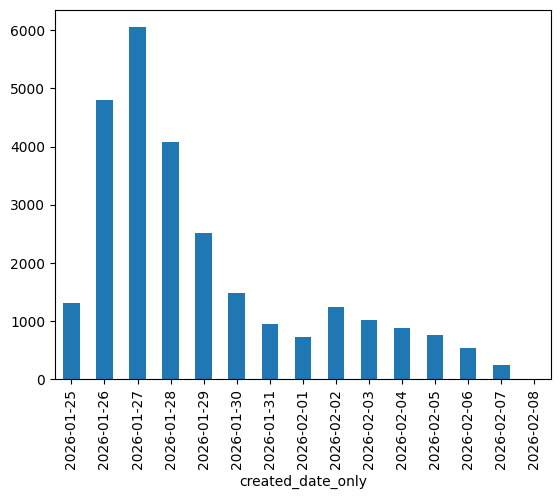

In [186]:
df.created_date_only.value_counts().sort_index().plot(kind='bar')

In [187]:
df.borough.value_counts(normalize=True)

borough
BROOKLYN         0.322756
QUEENS           0.320541
STATEN ISLAND    0.156853
BRONX            0.113706
MANHATTAN        0.085993
Unspecified      0.000150
Name: proportion, dtype: float64

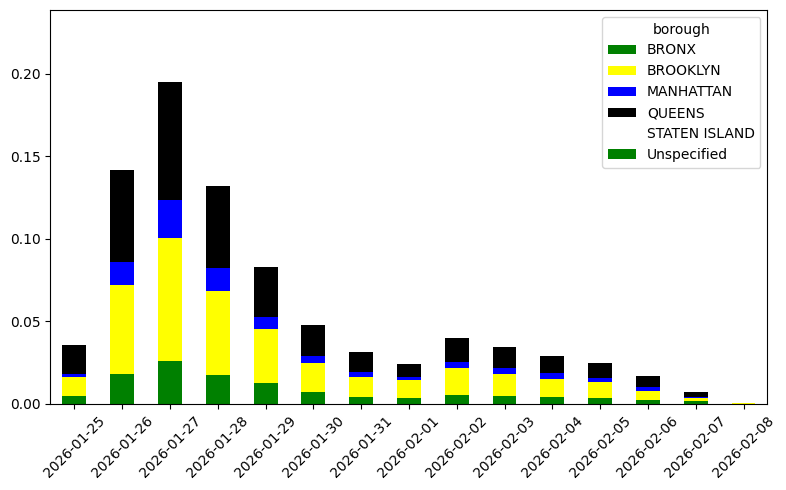

In [188]:
fig, ax= plt.subplots(figsize=(8,5))

ct_boro= pd.crosstab(df.created_date_only, df.borough, normalize=True)

ct_boro.plot(stacked=True, kind='bar', ax=ax, color=['green', 'yellow', 'blue', 'black', 'white'])

ax.set_xlabel('')

ax.set_xticklabels(ct_boro.index, rotation=45)

plt.tight_layout()
plt.show()

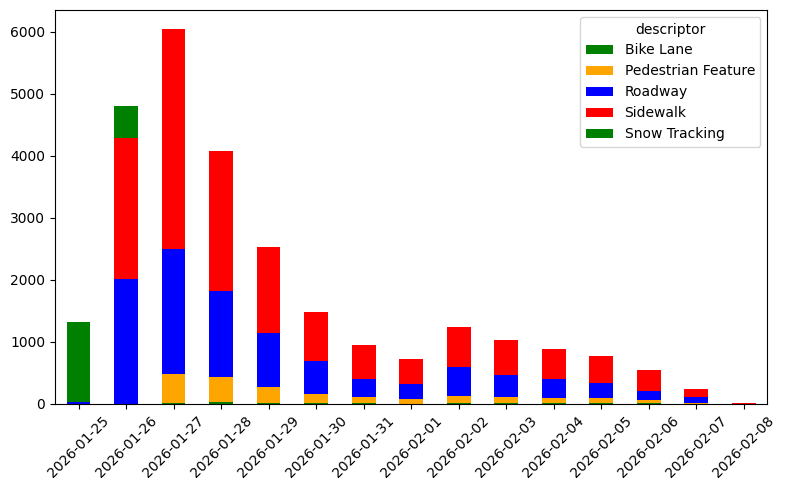

In [189]:
fig, ax= plt.subplots(figsize=(8,5))

color_mapping = {
    'Bike Lane': 'green',
    'Pedestrian Feature': 'orange',
    'Roadway': 'blue',
    'Sidewalk': 'red',
    'Snow Tracking': 'green'
}

ct_descriptor = pd.crosstab(df.created_date_only, df.descriptor)

colors = [color_mapping[col] for col in ct.columns]


ct_descriptor.plot(
    kind='bar',
    stacked=True,
    color=colors,
    ax=ax
)

ax.set_xlabel('')

ax.set_xticklabels(ct_descriptor.index, rotation=45)

plt.tight_layout()
plt.show()

In [190]:
df.status.value_counts(normalize=True)

status
Closed         0.917612
In Progress    0.082388
Name: proportion, dtype: float64

In [191]:
df[df.descriptor == 'Sidewalk'].resolution_description.value_counts(normalize=True, dropna=False)

resolution_description
The Department of Sanitation investigated this complaint and found no violation at the location.                                                                                                                                    0.590474
None                                                                                                                                                                                                                                0.150863
The Department of Sanitation investigated this complaint and found no condition at the location.                                                                                                                                    0.150790
The Department of Sanitation investigated this complaint and issued a Notice of Violation.                                                                                                                                          0.066188
The Department of Sanitation 

In [192]:
df.columns

Index(['unique_key', 'created_date', 'closed_date', 'agency', 'agency_name',
       'complaint_type', 'descriptor', 'descriptor_2', 'location_type',
       'status', 'resolution_description', 'resolution_action_updated_date',
       'community_board', 'police_precinct', 'borough',
       'open_data_channel_type', 'park_facility_name', 'park_borough',
       'bridge_highway_name', 'bridge_highway_direction', 'road_ramp',
       'bridge_highway_segment', 'incident_zip', 'incident_address',
       'street_name', 'cross_street_1', 'cross_street_2',
       'intersection_street_1', 'intersection_street_2', 'address_type',
       'city', 'landmark', 'council_district', 'bbl',
       'x_coordinate_state_plane', 'y_coordinate_state_plane', 'latitude',
       'longitude', 'location', 'created_date_only', 'closed_date_only',
       'resolution_action_updated_date_only', 'minutes_to_close',
       'hours_to_close'],
      dtype='object')

In [340]:
df.incident_zip.value_counts(normalize=True).head(10)

incident_zip
10314    0.028011
10301    0.021820
10312    0.020159
11385    0.016686
11229    0.015138
11230    0.015100
10306    0.014723
11234    0.014232
10304    0.013854
11101    0.013628
Name: proportion, dtype: float64

In [337]:
df[
    (df.status=='Closed') & (df.descriptor == 'Sidewalk')
    ].groupby('resolution_description').hours_to_close.median().reset_index().sort_values('hours_to_close')

,resolution_description,hours_to_close
10,The Department of Sanitation plowed the area.,100.131944
3,"The Department of Sanitation has investigated the complaint and addressed the issue. If the problem persists, call 311 to enter a new complaint. If you are outside of New York City, please call (212) NEW-YORK (212-639-9675).",105.650833
12,The Department of Sanitation will address the situation at the location by providing educational outreach about proper sanitation procedures.,107.198333
7,The Department of Sanitation investigated this complaint and issued a Notice of Violation.,119.943889
11,The Department of Sanitation removed the items.,123.479722
8,The Department of Sanitation investigated this complaint and no DSNY related conditions/violations were observed. Location will be referred to the appropriate agency for further action.,159.381111
5,The Department of Sanitation investigated this complaint and found no condition at the location.,165.527500
0,The Department of Sanitation cleaned the location.,166.355556
6,The Department of Sanitation investigated this complaint and found no violation at the location.,173.059444
2,The Department of Sanitation found an open service request already exists for the same location.,179.019861


In [194]:
df.columns

Index(['unique_key', 'created_date', 'closed_date', 'agency', 'agency_name',
       'complaint_type', 'descriptor', 'descriptor_2', 'location_type',
       'status', 'resolution_description', 'resolution_action_updated_date',
       'community_board', 'police_precinct', 'borough',
       'open_data_channel_type', 'park_facility_name', 'park_borough',
       'bridge_highway_name', 'bridge_highway_direction', 'road_ramp',
       'bridge_highway_segment', 'incident_zip', 'incident_address',
       'street_name', 'cross_street_1', 'cross_street_2',
       'intersection_street_1', 'intersection_street_2', 'address_type',
       'city', 'landmark', 'council_district', 'bbl',
       'x_coordinate_state_plane', 'y_coordinate_state_plane', 'latitude',
       'longitude', 'location', 'created_date_only', 'closed_date_only',
       'resolution_action_updated_date_only', 'minutes_to_close',
       'hours_to_close'],
      dtype='object')

In [195]:
df[['closed_date','resolution_action_updated_date']]

,closed_date,resolution_action_updated_date
0,2026-01-25 12:05:06,2026-01-25T12:05:10.000
1,2026-01-25 20:35:08,2026-01-25T20:35:15.000
2,2026-01-25 19:35:09,2026-01-25T19:35:22.000
3,2026-01-25 20:26:13,2026-01-25T20:26:16.000
4,2026-01-25 20:16:39,2026-01-25T20:16:44.000
...,...,...
26625,2026-02-06 21:34:53,2026-02-05T14:37:53.000
26626,2026-02-07 15:58:01,2026-02-07T15:58:07.000
26627,2026-02-06 02:45:54,2026-02-06T02:46:00.000
26628,2026-02-04 18:21:23,2026-02-04T16:55:12.000


In [206]:
df[df.descriptor == 'Sidewalk'].closed_date_only.value_counts(normalize=True).reset_index().sort_values('proportion', ascending=False)

,closed_date_only,proportion
0,2026-02-05,0.186875
1,2026-02-04,0.184824
2,2026-02-06,0.180723
3,2026-02-03,0.176365
4,2026-02-07,0.149278
5,2026-02-02,0.070751
6,2026-02-01,0.026403
7,2026-01-30,0.008032
8,2026-01-29,0.007434
9,2026-01-31,0.006067


In [223]:
df.columns

Index(['unique_key', 'created_date', 'closed_date', 'agency', 'agency_name',
       'complaint_type', 'descriptor', 'descriptor_2', 'location_type',
       'status', 'resolution_description', 'resolution_action_updated_date',
       'community_board', 'police_precinct', 'borough',
       'open_data_channel_type', 'park_facility_name', 'park_borough',
       'bridge_highway_name', 'bridge_highway_direction', 'road_ramp',
       'bridge_highway_segment', 'incident_zip', 'incident_address',
       'street_name', 'cross_street_1', 'cross_street_2',
       'intersection_street_1', 'intersection_street_2', 'address_type',
       'city', 'landmark', 'council_district', 'bbl',
       'x_coordinate_state_plane', 'y_coordinate_state_plane', 'latitude',
       'longitude', 'location', 'created_date_only', 'closed_date_only',
       'resolution_action_updated_date_only', 'minutes_to_close',
       'hours_to_close'],
      dtype='object')

In [219]:
df.resolution_description.value_counts(normalize=True).reset_index().sort_values('proportion')

,resolution_description,proportion
15,The Department of Sanitation investigated this complaint and sanded the area.,0.000367
13,The Department of Sanitation collected the requested items.,0.000408
14,The Department of Sanitation has sent this complaint to the appropriate district garage or bureau for further action.,0.000408
12,The Department of Sanitation investigated and found this complaint to be out of jurisdiction. The Department of Sanitation reviewed this and found it not to be meeting the criteria for a complaint or service request.,0.001184
11,The Department of Sanitation found an open service request already exists for the same location.,0.004082
10,The Department of Sanitation investigated this complaint and no DSNY related conditions/violations were observed. Location will be referred to the appropriate agency for further action.,0.009062
9,The Department of Sanitation will address the situation at the location by providing educational outreach about proper sanitation procedures.,0.009348
8,The Department of Sanitation removed the items.,0.012451
7,The Department of Sanitation investigated this complaint and issued a Notice of Violation.,0.038331
6,The Department of Sanitation cleaned the location.,0.048047


In [ ]:
pd.crosstab(
    df.descriptor, df.resolution_description,
    normalize='index', margins=True
)

resolution_description,The Department of Sanitation cleaned the location.,The Department of Sanitation collected the requested items.,The Department of Sanitation found an open service request already exists for the same location.,"The Department of Sanitation has investigated the complaint and addressed the issue. If the problem persists, call 311 to enter a new complaint. If you are outside of New York City, please call (212) NEW-YORK (212-639-9675).",The Department of Sanitation has sent this complaint to the appropriate district garage or bureau for further action.,The Department of Sanitation investigated and found this complaint to be out of jurisdiction. The Department of Sanitation reviewed this and found it not to be meeting the criteria for a complaint or service request.,The Department of Sanitation investigated this complaint and found no condition at the location.,The Department of Sanitation investigated this complaint and found no violation at the location.,The Department of Sanitation investigated this complaint and issued a Notice of Violation.,The Department of Sanitation investigated this complaint and no DSNY related conditions/violations were observed. Location will be referred to the appropriate agency for further action.,The Department of Sanitation investigated this complaint and salted the area.,The Department of Sanitation investigated this complaint and sanded the area.,The Department of Sanitation plowed the area.,The Department of Sanitation removed the items.,The Department of Sanitation will address the situation at the location by providing educational outreach about proper sanitation procedures.,Your report was submitted and will be used to monitor snow conditions around the City. The Department of Sanitation has a winter storm operation currently underway and cannot respond to individual requests at this time. No further status will be available about your report.
descriptor,,,,,,,,,,,,,,,,
Bike Lane,0.096491,0.008772,0.008772,0.043860,0.000000,0.000000,0.166667,0.000000,0.008772,0.061404,0.192982,0.000000,0.324561,0.087719,0.000000,0.000000
Pedestrian Feature,0.168076,0.001057,0.010571,0.054440,0.000000,0.001586,0.112579,0.000000,0.004757,0.047569,0.258457,0.000529,0.225687,0.087209,0.027484,0.000000
Roadway,0.082496,0.000558,0.007703,0.167783,0.000000,0.002456,0.094441,0.000000,0.001786,0.004019,0.396852,0.000893,0.210092,0.011833,0.019089,0.000000
Sidewalk,0.009306,0.000171,0.000854,0.027235,0.000854,0.000342,0.177580,0.695381,0.077948,0.007598,0.000085,0.000000,0.000085,0.002049,0.000512,0.000000
Snow Tracking,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
All,0.048047,0.000408,0.004082,0.078785,0.000408,0.001184,0.128914,0.332490,0.038331,0.009062,0.166020,0.000367,0.095808,0.012451,0.009348,0.074295


In [ ]:
df[df.descriptor == 'Sidewalk'].groupby('resolution_description').hours_to_close.median().reset_index().sort_values('hours_to_close')

In [51]:
import geopandas as gpd

gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.longitude, df.latitude) )
gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 26630 entries, 0 to 26629
Data columns (total 42 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   unique_key                      26630 non-null  object        
 1   created_date                    26630 non-null  datetime64[ns]
 2   closed_date                     24436 non-null  datetime64[ns]
 3   agency                          26630 non-null  object        
 4   agency_name                     26630 non-null  object        
 5   complaint_type                  26630 non-null  object        
 6   descriptor                      26630 non-null  object        
 7   descriptor_2                    26630 non-null  object        
 8   location_type                   26630 non-null  object        
 9   status                          26630 non-null  object        
 10  resolution_description          24497 non-null  object        

In [65]:
gdf[(gdf.longitude.isna()) | (gdf.latitude.isna())].shape[0] / gdf.shape[0]

0.0249342846413819

In [66]:
cleaned_gdf = gdf[(gdf.longitude.notna()) & (gdf.latitude.notna())]

cleaned_gdf.shape

(25966, 42)

In [232]:
cleaned_gdf.groupby('descriptor')['incident_zip'].value_counts().groupby(level=0).head(5)


descriptor          incident_zip
Bike Lane           11215             8
                    10019             6
                    11101             6
                    11104             6
                    10002             5
Pedestrian Feature  11101            43
                    11201            39
                    11234            39
                    11375            37
                    10461            35
Roadway             10301           349
                    10314           349
                    10312           244
                    10304           197
                    10306           184
Sidewalk            11385           282
                    11101           252
                    11229           252
                    10314           251
                    11215           245
Snow Tracking       10314            96
                    10312            68
                    10301            67
                    10304            58
       

incident_zip
10001    Axes(0.125,0.11;0.775x0.77)
10002    Axes(0.125,0.11;0.775x0.77)
10003    Axes(0.125,0.11;0.775x0.77)
10004    Axes(0.125,0.11;0.775x0.77)
10005    Axes(0.125,0.11;0.775x0.77)
                    ...             
11691    Axes(0.125,0.11;0.775x0.77)
11692    Axes(0.125,0.11;0.775x0.77)
11693    Axes(0.125,0.11;0.775x0.77)
11694    Axes(0.125,0.11;0.775x0.77)
11697    Axes(0.125,0.11;0.775x0.77)
Name: proportion, Length: 189, dtype: object

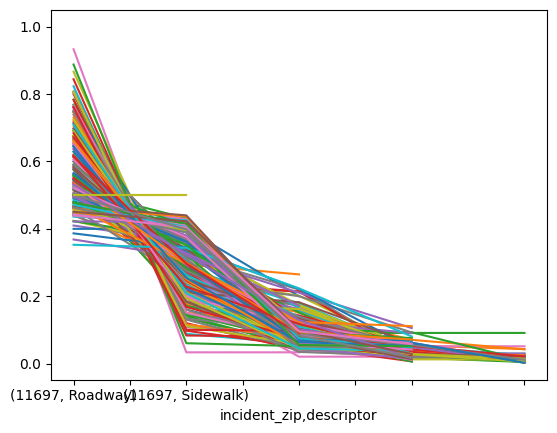

In [76]:
cleaned_gdf.groupby('descriptor').size()

descriptor
Bike Lane               113
Pedestrian Feature     1877
Roadway                8558
Sidewalk              13677
Snow Tracking          1741
dtype: int64

/Users/keenansmacbookairm3/.pyenv/versions/3.12.0/lib/python3.12/site-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


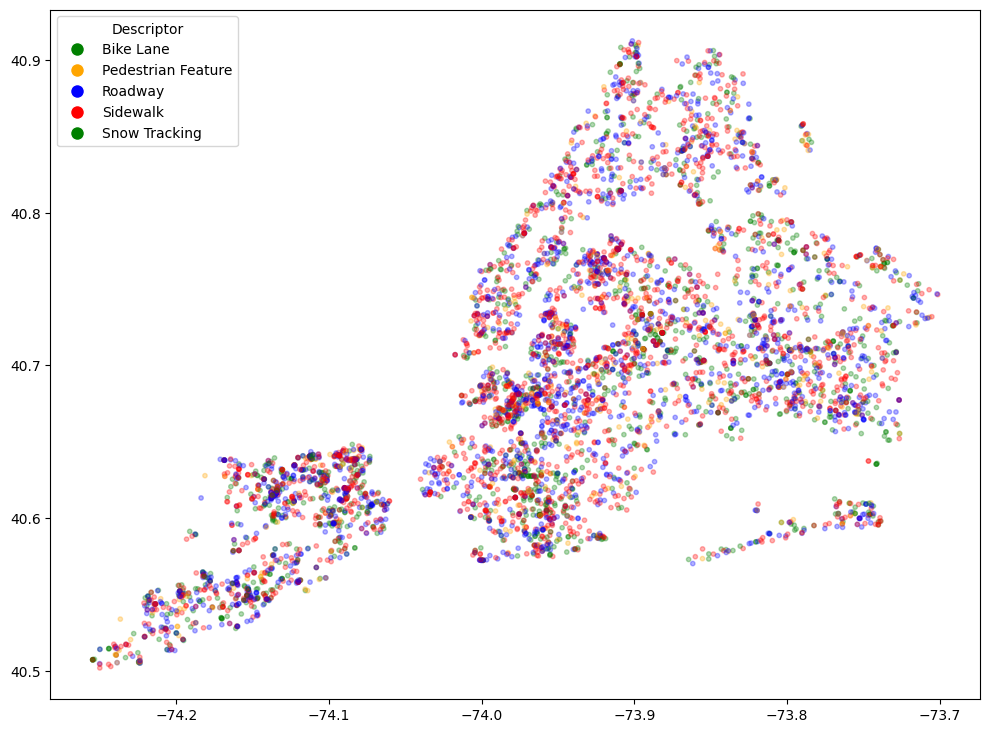

In [138]:
color_mapping = {
    'Bike Lane': 'green',
    'Pedestrian Feature': 'orange',
    'Roadway': 'blue',
    'Sidewalk': 'red',
    'Snow Tracking': 'green'
}

# Map colors to a new column
cleaned_gdf['color'] = cleaned_gdf['descriptor'].map(color_mapping)

# Plot
fig, ax = plt.subplots(figsize=(10,8))
cleaned_gdf[cleaned_gdf.created_date<='2026-01-27'].plot(
    ax=ax,
    marker='o',
    color=cleaned_gdf['color'],
    markersize=10, 
    alpha=0.3,

)

legend_elements = [
    Line2D([0], [0], marker='o', color='w', label=label,
           markerfacecolor=color, markersize=10)
    for label, color in color_mapping.items()
]

ax.legend(handles=legend_elements, title="Descriptor")

plt.tight_layout()
plt.show()


/Users/keenansmacbookairm3/.pyenv/versions/3.12.0/lib/python3.12/site-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


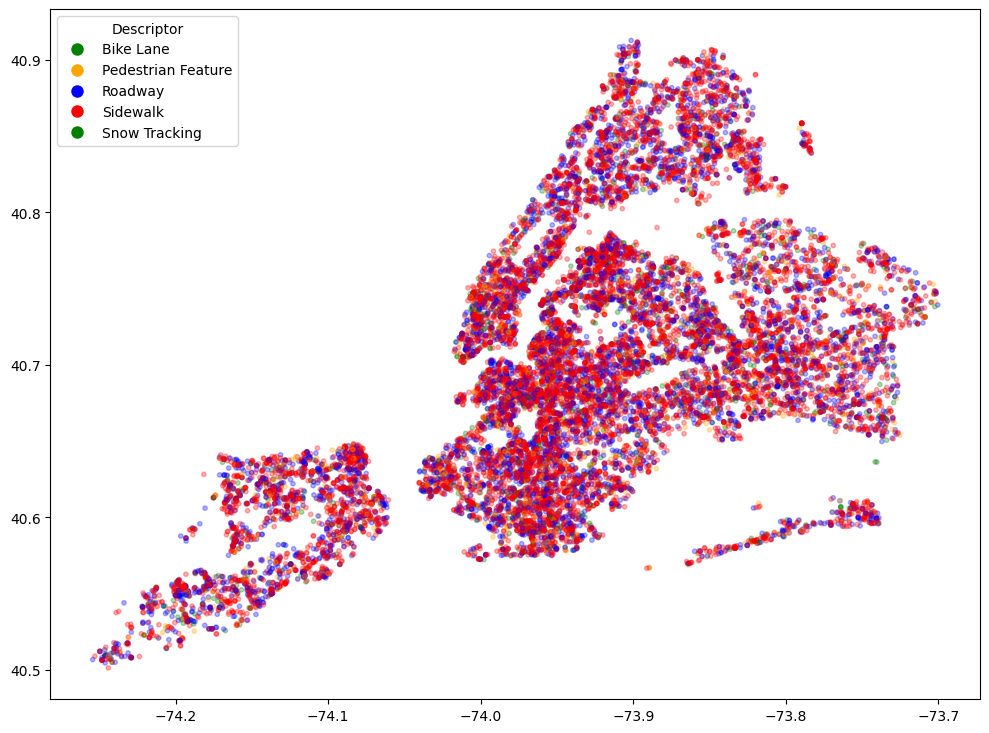

In [137]:
color_mapping = {
    'Bike Lane': 'green',
    'Pedestrian Feature': 'orange',
    'Roadway': 'blue',
    'Sidewalk': 'red',
    'Snow Tracking': 'green'
}

# Map colors to a new column
cleaned_gdf['color'] = cleaned_gdf['descriptor'].map(color_mapping)

# Plot
fig, ax = plt.subplots(figsize=(10,8))
cleaned_gdf[cleaned_gdf.created_date>'2026-01-27'].plot(
    ax=ax,
    marker='o',
    color=cleaned_gdf['color'],
    markersize=10, 
    alpha=0.3,

)

legend_elements = [
    Line2D([0], [0], marker='o', color='w', label=label,
           markerfacecolor=color, markersize=10)
    for label, color in color_mapping.items()
]

ax.legend(handles=legend_elements, title="Descriptor")

plt.tight_layout()
plt.show()


In [53]:
df.created_date_only.value_counts().sort_index()

created_date_only
2026-01-25    1315
2026-01-26    4805
2026-01-27    6048
2026-01-28    4072
2026-01-29    2522
              ... 
2026-02-04     889
2026-02-05     770
2026-02-06     543
2026-02-07     241
2026-02-08       7
Name: count, Length: 15, dtype: int64

In [54]:
df.borough.value_counts()

borough
BROOKLYN         8595
QUEENS           8536
STATEN ISLAND    4177
BRONX            3028
MANHATTAN        2290
Unspecified         4
Name: count, dtype: int64

In [55]:
gdf.geometry.value_counts(normalize=True)

geometry
POINT EMPTY                   0.024934
POINT (-73.96023 40.66334)    0.001051
POINT (-74.16428 40.62068)    0.000789
POINT (-73.92403 40.74379)    0.000713
POINT (-73.92435 40.7615)     0.000676
                                ...   
POINT (-73.97264 40.59264)    0.000038
POINT (-73.95264 40.5756)     0.000038
POINT (-73.94822 40.72073)    0.000038
POINT (-73.96325 40.64174)    0.000038
POINT (-73.94333 40.67304)    0.000038
Name: proportion, Length: 20239, dtype: float64

In [56]:
gdf[gdf.geometry.isna()]

,unique_key,created_date,closed_date,agency,agency_name,complaint_type,descriptor,descriptor_2,location_type,status,resolution_description,resolution_action_updated_date,community_board,police_precinct,borough,open_data_channel_type,park_facility_name,park_borough,bridge_highway_name,bridge_highway_direction,road_ramp,bridge_highway_segment,incident_zip,incident_address,street_name,cross_street_1,cross_street_2,intersection_street_1,intersection_street_2,address_type,city,landmark,council_district,bbl,x_coordinate_state_plane,y_coordinate_state_plane,latitude,longitude,location,created_date_only,minutes_to_close,geometry


In [57]:
zip_counts = (
    df["incident_zip"]
    .astype(str)
    .str.zfill(5)
    .value_counts()
    .rename("complaint_count")
    .reset_index()
    .rename(columns={"index": "zip"})
)


In [58]:
import requests

shapefile_response = requests.get('https://data.cityofnewyork.us/resource/pri4-ifjk.json')
shapefile_json = shapefile_response.json()
shapefile_df = pd.DataFrame(shapefile_json)


from shapely.geometry import shape


# Convert the 'the_geom' column to shapely geometries
shapefile_df['geometry'] = shapefile_df['the_geom'].apply(shape)
shapefile_gdf = gpd.GeoDataFrame(shapefile_df, geometry='geometry')

In [59]:
zip_counts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 190 entries, 0 to 189
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   incident_zip     190 non-null    object
 1   complaint_count  190 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 3.1+ KB


In [245]:
shapefile_gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 178 entries, 0 to 177
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   modzcta   178 non-null    object  
 1   label     178 non-null    object  
 2   zcta      178 non-null    object  
 3   pop_est   178 non-null    object  
 4   the_geom  178 non-null    object  
 5   geometry  178 non-null    geometry
dtypes: geometry(1), object(5)
memory usage: 8.5+ KB


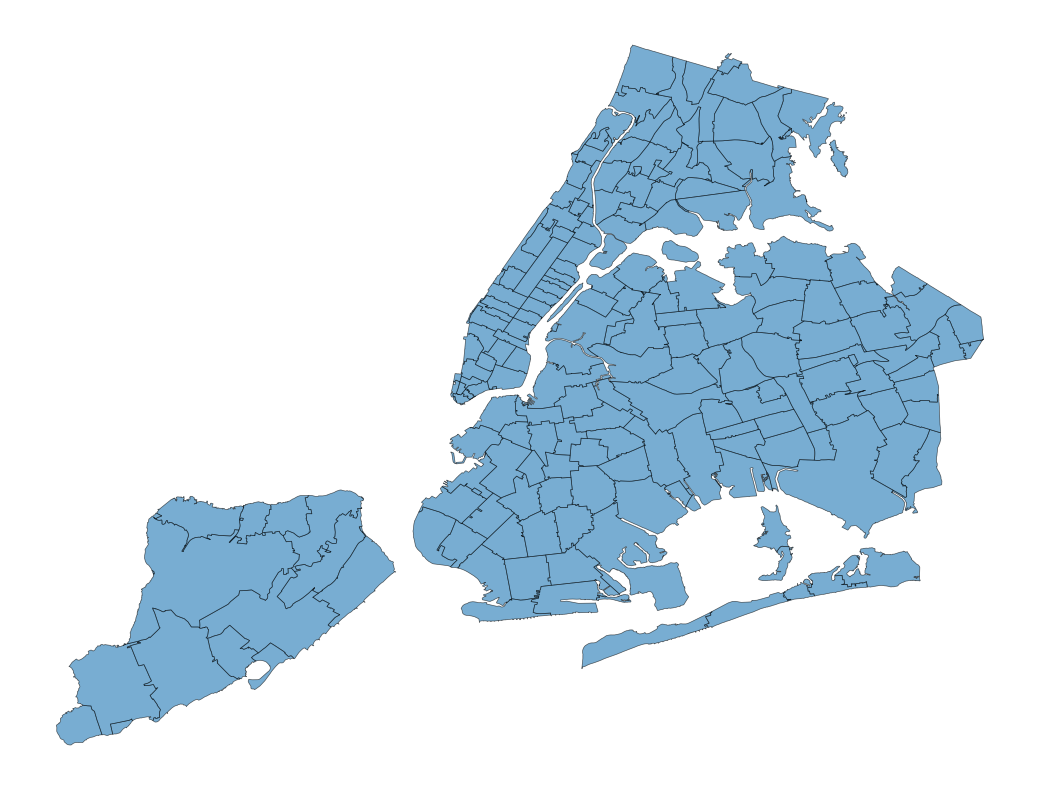

In [ ]:
fig, ax= plt.subplots(figsize=(15,10))
shapefile_gdf.plot(
    ax=ax,
    edgecolor='black',
    linewidth=0.5,
    alpha=0.6
    )


cleaned_gdf.groupby('incident_zip')['descriptor'].value_counts(normalize=True).groupby(level=0).plot()
"""

ax.set_axis_off()
plt.show()

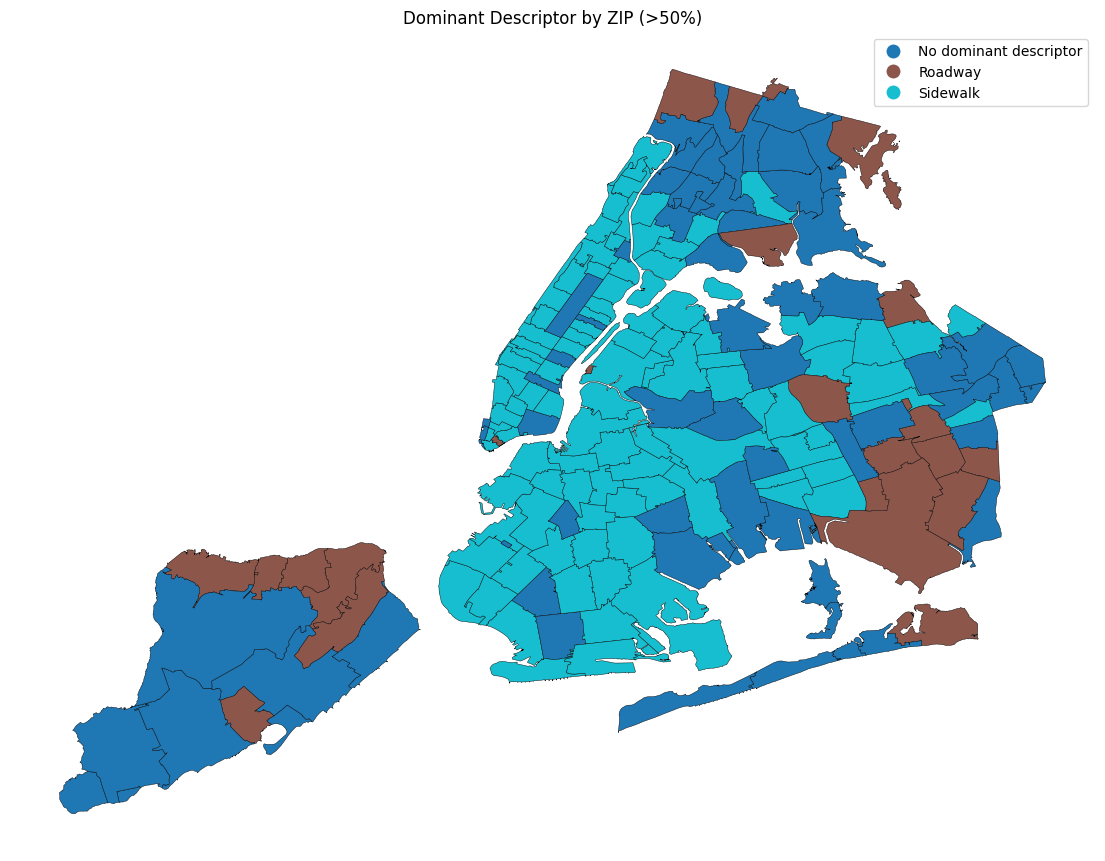

In [261]:
desc_pct = (
    cleaned_gdf
    .groupby(['incident_zip', 'descriptor'])
    .size()
    .rename('count')
    .reset_index()
)

desc_pct['pct'] = desc_pct['count'] / desc_pct.groupby('incident_zip')['count'].transform('sum')

dominant_desc = (
    desc_pct[desc_pct['pct'] > 0.5]
    .sort_values('pct', ascending=False)
    .drop_duplicates('incident_zip')[['incident_zip', 'descriptor']]
)

map_gdf = shapefile_gdf.merge(
    dominant_desc,
    left_on='modzcta',
    right_on='incident_zip',
    how='left'
)

map_gdf['descriptor'] = map_gdf['descriptor'].fillna('No dominant descriptor')

fig, ax = plt.subplots(figsize=(14, 14))
map_gdf.plot(
    column='descriptor',
    categorical=True,
    legend=True,
    linewidth=0.3,
    edgecolor='black',
    ax=ax
)

ax.set_title("Dominant Descriptor by ZIP (>50%)")
ax.axis('off')
plt.show()


In [279]:
import datetime

post_storm_gdf = cleaned_gdf[cleaned_gdf['created_date_only'] >= datetime.date(2026, 1, 28)]

post_storm_gdf.value_counts('resolution_description', normalize=True)

resolution_description
The Department of Sanitation investigated this complaint and found no violation at the location.                                                                                                                                                                                      0.334054
The Department of Sanitation investigated this complaint and salted the area.                                                                                                                                                                                                         0.167708
The Department of Sanitation investigated this complaint and found no condition at the location.                                                                                                                                                                                      0.145042
The Department of Sanitation plowed the area.                                                                       

In [277]:
df.columns

Index(['unique_key', 'created_date', 'closed_date', 'agency', 'agency_name',
       'complaint_type', 'descriptor', 'descriptor_2', 'location_type',
       'status', 'resolution_description', 'resolution_action_updated_date',
       'community_board', 'police_precinct', 'borough',
       'open_data_channel_type', 'park_facility_name', 'park_borough',
       'bridge_highway_name', 'bridge_highway_direction', 'road_ramp',
       'bridge_highway_segment', 'incident_zip', 'incident_address',
       'street_name', 'cross_street_1', 'cross_street_2',
       'intersection_street_1', 'intersection_street_2', 'address_type',
       'city', 'landmark', 'council_district', 'bbl',
       'x_coordinate_state_plane', 'y_coordinate_state_plane', 'latitude',
       'longitude', 'location', 'created_date_only', 'closed_date_only',
       'resolution_action_updated_date_only', 'minutes_to_close',
       'hours_to_close'],
      dtype='object')

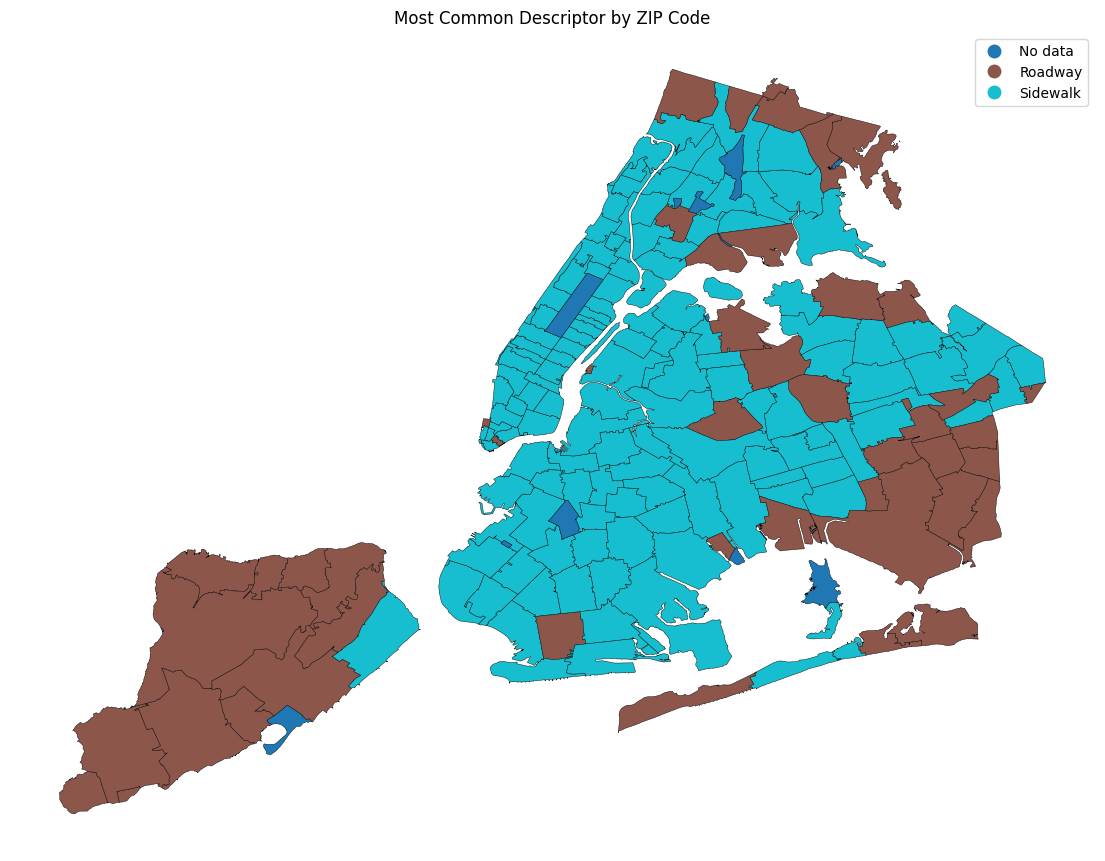

In [263]:
desc_counts = (
    cleaned_gdf
    .groupby(['incident_zip', 'descriptor'])
    .size()
    .rename('count')
    .reset_index()
)

dominant_desc = (
    desc_counts
    .sort_values(['incident_zip', 'count'], ascending=[True, False])
    .drop_duplicates('incident_zip')[['incident_zip', 'descriptor']]
)

map_gdf = shapefile_gdf.merge(
    dominant_desc,
    left_on='modzcta',
    right_on='incident_zip',
    how='left'
)

map_gdf['descriptor'] = map_gdf['descriptor'].fillna('No data')

fig, ax = plt.subplots(figsize=(14, 14))
map_gdf.plot(
    column='descriptor',
    categorical=True,
    legend=True,
    linewidth=0.3,
    edgecolor='black',
    ax=ax
)

ax.set_title("Most Common Descriptor by ZIP Code")
ax.axis('off')
plt.show()

In [ ]:
zip_counts

,incident_zip,complaint_count
0,10314,232
1,10301,207
2,10312,148
3,10304,127
4,10309,121
...,...,...
172,11109,2
173,10030,2
174,10004,2
175,10005,2


In [61]:
merged_gdf = shapefile_gdf.merge(zip_counts, left_on='modzcta', right_on='incident_zip', how='left')
merged_gdf['complaint_count'] = merged_gdf['complaint_count'].fillna(0).astype(int)

merged_gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 178 entries, 0 to 177
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   modzcta          178 non-null    object  
 1   label            178 non-null    object  
 2   zcta             178 non-null    object  
 3   pop_est          178 non-null    object  
 4   the_geom         178 non-null    object  
 5   geometry         178 non-null    geometry
 6   incident_zip     177 non-null    object  
 7   complaint_count  178 non-null    int64   
dtypes: geometry(1), int64(1), object(6)
memory usage: 11.3+ KB


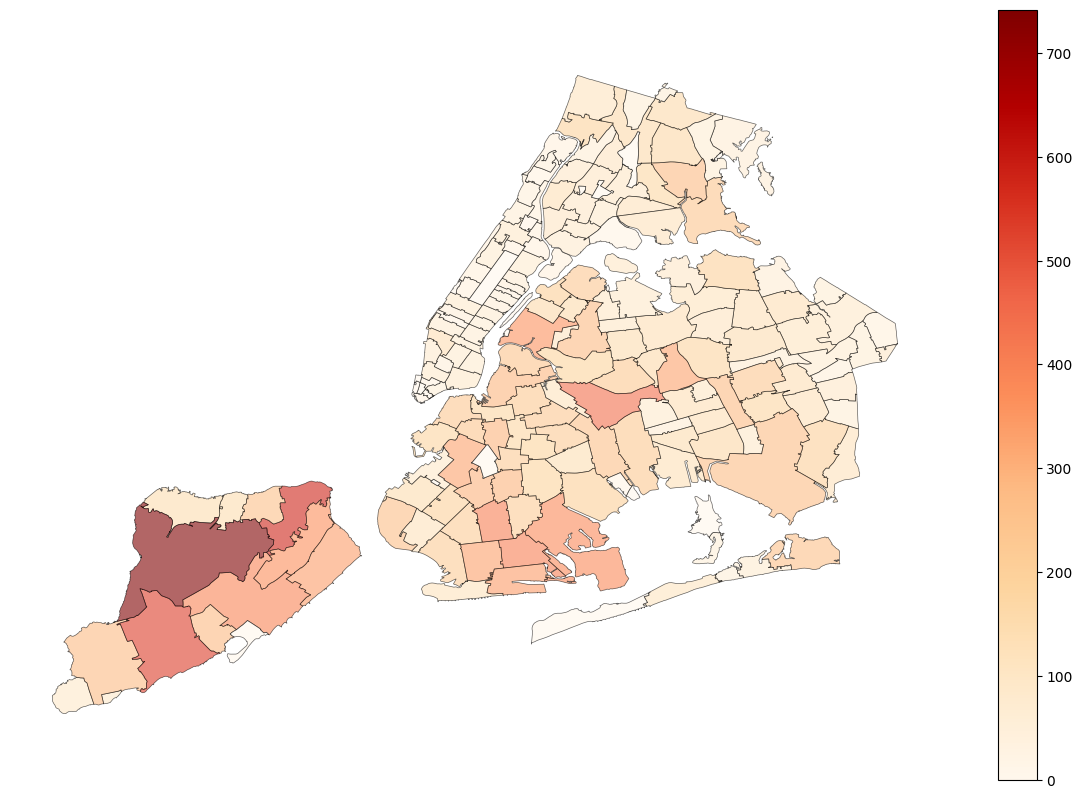

In [62]:

fig, ax = plt.subplots(figsize=(15, 10))
merged_gdf.plot(ax=ax, column='complaint_count', cmap='OrRd', edgecolor='black', linewidth=0.5, alpha=0.6, legend=True)
ax.set_axis_off()
plt.show()